<a href="https://colab.research.google.com/github/Archi5094/complaint_chatbot/blob/main/moonsoon_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Colab cell 1: install libs
!pip install -q pandas numpy scikit-learn lightgbm xgboost catboost optuna shap matplotlib seaborn category_encoders

# (optional) mount Google Drive to save outputs / load large files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [18]:

import pandas as pd, json, os

def load_csv(path):
    return pd.read_csv(path)

def load_json_smart(path):
    try:
        return pd.read_json(path)
    except Exception:
        try:
            return pd.read_json(path, lines=True)
        except Exception:
            with open(path,'r') as f:
                data = json.load(f)
            return pd.DataFrame(data)

train = load_csv('/content/train_flag.csv')
accounts = load_json_smart('/content/accounts_data_train.json')
enquiries = load_json_smart('/content/enquiry_data_train.json')

train.shape, accounts.shape, enquiries.shape


((261383, 3), (223918, 116), (261383, 69))

In [21]:
import json
import pandas as pd

# Example for enquiries.json
with open("/content/enquiry_data_train.json", "r") as f:
    raw = json.load(f)   # this will be a list of lists

# Flatten list of lists into one big list of dicts
flat = [item for sublist in raw for item in sublist]

enquiries = pd.DataFrame(flat)
print(enquiries.shape)
print(enquiries.head())

# Same for accounts.json
with open("/content/accounts_data_train.json", "r") as f:
    raw = json.load(f)

flat = [item for sublist in raw for item in sublist]
accounts = pd.DataFrame(flat)
print(accounts.shape)
print(accounts.head())


(1909926, 4)
                enquiry_type  enquiry_amt enquiry_date          uid
0           Interbank credit       168839   2020-11-08  AAA08065248
1       Mobile operator loan       268392   2020-09-20  AAA08065248
2       Mobile operator loan        36082   2020-06-19  AAA08065248
3           Interbank credit       180467   2019-10-22  AAA08065248
4  Cash loan (non-earmarked)       227459   2020-05-24  AAA08065248
(1245310, 7)
       credit_type  loan_amount  amount_overdue   open_date closed_date  \
0  Consumer credit   272745.000             0.0  2018-09-22  2020-02-22   
1  Consumer credit     4500.000             0.0  2018-03-08  2019-07-25   
2      Credit card    80996.445             0.0  2020-06-29         NaN   
3  Consumer credit    43771.500             0.0  2020-06-09  2020-09-09   
4      Credit card    10480.500             0.0  2014-09-10         NaN   

                                 payment_hist_string          uid  
0  00000000000000000000001000000000000000000000

In [19]:
print(train.head())
print(enquiries.head())
print(accounts.head())

           uid NAME_CONTRACT_TYPE  TARGET
0  XDA69787158         Cash loans       0
1  BSE47789733         Cash loans       0
2  NTJ92213825         Cash loans       0
3  TCQ47571695         Cash loans       0
4  WJZ68772744         Cash loans       0
                                                  0   \
0  {'enquiry_type': 'Interbank credit', 'enquiry_...   
1  {'enquiry_type': 'Cash loans', 'enquiry_amt': ...   
2  {'enquiry_type': 'Revolving loans', 'enquiry_a...   
3  {'enquiry_type': 'Loan for purchase of shares ...   
4  {'enquiry_type': 'Mobile operator loan', 'enqu...   

                                                  1   \
0  {'enquiry_type': 'Mobile operator loan', 'enqu...   
1  {'enquiry_type': 'Interbank credit', 'enquiry_...   
2  {'enquiry_type': 'Consumer credit', 'enquiry_a...   
3  {'enquiry_type': 'Loan for working capital rep...   
4                                               None   

                                                  2   \
0  {'enquiry_type'

In [22]:
#EDA
import numpy as np
print("Train sample:")
display(train.head())
print("\nTARGET distribution:")
print(train['TARGET'].value_counts(dropna=False))
print("\nMissing per file:")
print(train.isna().sum().sort_values(ascending=False).head())
print(accounts.info())
print(enquiries.info())


Train sample:


,uid,NAME_CONTRACT_TYPE,TARGET
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0
3,TCQ47571695,Cash loans,0
4,WJZ68772744,Cash loans,0



TARGET distribution:
TARGET
0    240326
1     21057
Name: count, dtype: int64

Missing per file:
uid                   0
NAME_CONTRACT_TYPE    0
TARGET                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245310 entries, 0 to 1245309
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   credit_type          1245310 non-null  object 
 1   loan_amount          1245307 non-null  float64
 2   amount_overdue       1245310 non-null  float64
 3   open_date            1245310 non-null  object 
 4   closed_date          782275 non-null   object 
 5   payment_hist_string  1245310 non-null  object 
 6   uid                  1245310 non-null  object 
dtypes: float64(2), object(5)
memory usage: 66.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909926 entries, 0 to 1909925
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   enquiry_ty

In [23]:
# Force string column names
train.columns = train.columns.map(str)
accounts.columns = accounts.columns.map(str)
enquiries.columns = enquiries.columns.map(str)

# Date parsing
for col in ["open_date", "closed_date"]:
    if col in accounts.columns:
        accounts[col] = pd.to_datetime(accounts[col], errors="coerce")

if "enquiry_date" in enquiries.columns:
    enquiries["enquiry_date"] = pd.to_datetime(enquiries["enquiry_date"], errors="coerce")

if "application_date" in train.columns:
    train["application_date"] = pd.to_datetime(train["application_date"], errors="coerce")

# Numeric parsing
for col in ["loan_amount", "amount_overdue"]:
    if col in accounts.columns:
        accounts[col] = pd.to_numeric(accounts[col], errors="coerce")

if "enquiry_amt" in enquiries.columns:
    enquiries["enquiry_amt"] = pd.to_numeric(enquiries["enquiry_amt"], errors="coerce")

if "application_date" in train.columns:
    ref_dates = train.set_index("uid")["application_date"].to_dict()
    ref_date = None
else:
    acc_max_date = accounts[["open_date", "closed_date"]].max().max()
    enq_max_date = enquiries["enquiry_date"].max()
    ref_date = max(acc_max_date, enq_max_date)
    print("Reference date selected:", ref_date)


Reference date selected: 2021-01-01 00:00:00


In [24]:
#payment history per account row
import numpy as np

def parse_payment_hist(s):
    # returns dict of derived metrics from the triple-digit format
    res = {'ph_num_months':0, 'ph_max_days':0, 'ph_mean_days':0, 'ph_n_overdue_months':0, 'ph_last_3_overdue':0}
    if pd.isna(s) or not isinstance(s, str) or len(s)==0:
        return res
    chunks = [s[i:i+3] for i in range(0, len(s), 3)]
    vals = []
    for c in chunks:
        try:
            v = int(c)
            vals.append(v)
        except:
            # if non-numeric, treat as 0
            vals.append(0)
    if len(vals)==0:
        return res
    res['ph_num_months'] = len(vals)
    res['ph_max_days'] = int(max(vals))
    res['ph_mean_days'] = float(np.mean(vals))
    res['ph_n_overdue_months'] = int(sum(1 for v in vals if v>0))
    res['ph_last_3_overdue'] = int(sum(1 for v in vals[-3:] if v>0))
    return res

ph_df = accounts['payment_hist_string'].apply(parse_payment_hist).apply(pd.Series)
accounts = pd.concat([accounts, ph_df], axis=1)


In [25]:
today = pd.Timestamp('today')
accounts['closed_filled'] = accounts['closed_date'].fillna(today)
accounts['tenure_days'] = (accounts['closed_filled'] - accounts['open_date']).dt.days.clip(lower=0)
# fill NaNs for numeric fields so aggregations won't break
accounts['loan_amount'] = accounts['loan_amount'].fillna(0)
accounts['amount_overdue'] = accounts['amount_overdue'].fillna(0)


In [26]:
# groupby aggregations for accounts
agg_accounts = accounts.groupby('uid').agg(
    acc_num_accounts=('uid','size'),
    acc_total_loan_amount=('loan_amount','sum'),
    acc_mean_loan_amount=('loan_amount','mean'),
    acc_total_amount_overdue=('amount_overdue','sum'),
    acc_max_amount_overdue=('amount_overdue','max'),
    acc_mean_tenure_days=('tenure_days','mean'),
    acc_max_tenure_days=('tenure_days','max'),
    acc_ph_mean_days=('ph_mean_days','mean'),
    acc_ph_max_days=('ph_max_days','max'),
    acc_ph_n_overdue_months=('ph_n_overdue_months','sum'),
    acc_ph_last_3_overdue=('ph_last_3_overdue','sum')
).reset_index()
agg_accounts.fillna(0, inplace=True)
agg_accounts.head()


,uid,acc_num_accounts,acc_total_loan_amount,acc_mean_loan_amount,acc_total_amount_overdue,acc_max_amount_overdue,acc_mean_tenure_days,acc_max_tenure_days,acc_ph_mean_days,acc_ph_max_days,acc_ph_n_overdue_months,acc_ph_last_3_overdue
0,AAA09044550,2,277245.000,138622.500,0.0,0.0,511.00,518,2.106618,44.0,3.0,0.0
1,AAA10545297,1,80996.445,80996.445,0.0,0.0,1902.00,1902,0.000000,0.0,0.0,0.0
2,AAA14112888,1,43771.500,43771.500,0.0,0.0,92.00,92,0.000000,0.0,0.0,0.0
3,AAA20326915,8,591597.000,73949.625,0.0,0.0,1221.25,4021,23.810855,917.0,31.0,0.0
4,AAA31604840,5,1591960.500,318392.100,0.0,0.0,1513.40,3018,0.000000,0.0,0.0,0.0


In [27]:
# enquiries aggregations
enquiries['enquiry_date'] = pd.to_datetime(enquiries['enquiry_date'], errors='coerce')
enq_agg = enquiries.groupby('uid').agg(
    enq_num_enquiries=('uid','size'),
    enq_avg_amt=('enquiry_amt','mean'),
    enq_max_amt=('enquiry_amt','max'),
    enq_last_date=('enquiry_date','max')
).reset_index()
if 'application_date' in train.columns:
    enq_agg = enq_agg.merge(train[['uid','application_date']], on='uid', how='left')
    enq_agg['days_since_last_enquiry'] = (enq_agg['application_date'] - enq_agg['enq_last_date']).dt.days
else:
    reference_date = enquiries['enquiry_date'].max()
    enq_agg['days_since_last_enquiry'] = (reference_date - enq_agg['enq_last_date']).dt.days
enq_agg.fillna({'enq_avg_amt':0,'enq_num_enquiries':0,'days_since_last_enquiry':9999}, inplace=True)
enq_agg.head()


,uid,enq_num_enquiries,enq_avg_amt,enq_max_amt,enq_last_date,days_since_last_enquiry
0,AAA08065248,11,187696.181818,364751,2020-12-30,2
1,AAA09044550,26,102269.230769,197000,2020-12-29,3
2,AAA10545297,14,94071.428571,192000,2020-10-29,64
3,AAA14112888,15,97666.666667,185000,2020-07-05,180
4,AAA20326915,1,66000.000000,66000,2020-08-14,140


In [28]:
# merge features
data = train.merge(agg_accounts, on='uid', how='left').merge(enq_agg, on='uid', how='left')
# fill NaNs
data.fillna({
    'acc_num_accounts':0, 'acc_total_loan_amount':0, 'acc_mean_loan_amount':0,
    'acc_total_amount_overdue':0, 'enq_num_enquiries':0, 'enq_avg_amt':0
}, inplace=True)
display(data.head())


,uid,NAME_CONTRACT_TYPE,TARGET,acc_num_accounts,acc_total_loan_amount,acc_mean_loan_amount,acc_total_amount_overdue,acc_max_amount_overdue,acc_mean_tenure_days,acc_max_tenure_days,acc_ph_mean_days,acc_ph_max_days,acc_ph_n_overdue_months,acc_ph_last_3_overdue,enq_num_enquiries,enq_avg_amt,enq_max_amt,enq_last_date,days_since_last_enquiry
0,XDA69787158,Cash loans,0,1.0,450000.0,450000.0,0.0,0.0,2904.000000,2904.0,0.0,0.0,0.0,0.0,2,135500.000000,166000,2020-08-07,147
1,BSE47789733,Cash loans,0,1.0,110155.5,110155.5,0.0,0.0,30.000000,30.0,0.0,0.0,0.0,0.0,3,144333.333333,151000,2020-11-13,49
2,NTJ92213825,Cash loans,0,1.0,103783.5,103783.5,0.0,0.0,304.000000,304.0,0.0,0.0,0.0,0.0,4,120500.000000,167000,2020-09-17,106
3,TCQ47571695,Cash loans,0,3.0,672876.0,224292.0,0.0,0.0,1285.333333,2094.0,0.0,0.0,0.0,0.0,1,148000.000000,148000,2020-10-01,92
4,WJZ68772744,Cash loans,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,110318.181818,194000,2020-12-09,23


In [29]:
data['acc_overdue_ratio'] = data['acc_total_amount_overdue'] / (data['acc_total_loan_amount'] + 1e-6)
data['acc_avg_loan_per_acct'] = data['acc_total_loan_amount'] / (data['acc_num_accounts'] + 1e-6)
# categorize missing categories
for cat in ['NAME_CONTRACT_TYPE','credit_type','enquiry_type']:
    if cat in data.columns:
        data[cat] = data[cat].fillna('MISSING').astype(str)


In [32]:
# modeling utilities with ightGBM API
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

SEED = 123
target = data['TARGET']
features = [c for c in data.columns if c not in ['uid','TARGET','application_date','enq_last_date']]  # adjust if needed

# Convert any object/categorical to category dtype
for c in features:
    if data[c].dtype == 'object':
        data[c] = data[c].astype('category')

X = data[features]
y = target

def cv_lightgbm(X, y, params, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof = np.zeros(len(X))

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = LGBMClassifier(
            **params,
            n_estimators=5000,
            random_state=SEED
        )
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="auc",
            callbacks=[early_stopping(100), log_evaluation(100)]
        )
        oof[val_idx] = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y, oof)
    print("CV AUC:", auc)
    return auc

# Baseline params
params = {
    'learning_rate': 0.05,
    'num_leaves': 31
}

cv_lightgbm(X, y, params, n_splits=5)


[LightGBM] [Info] Number of positive: 16846, number of negative: 192260
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3507
[LightGBM] [Info] Number of data points in the train set: 209106, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080562 -> initscore=-2.434735
[LightGBM] [Info] Start training from score -2.434735
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.625325	valid_0's binary_logloss: 0.272558
[200]	valid_0's auc: 0.62355	valid_0's binary_logloss: 0.272704
Early stopping, best iteration is:
[108]	valid_0's auc: 0.625676	valid_0's binary_logloss: 0.272516
[LightGBM] [Info] Number of positive: 16845, number of negative: 192261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of tes

np.float64(0.6187010770810357)

In [33]:
#Optuna tuning with LGBMClassifier
import optuna

def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': SEED,
        'n_estimators': 5000
    }

    # handle imbalance
    pos = (y == 1).sum()
    neg = (y == 0).sum()
    param['scale_pos_weight'] = neg / pos if pos > 0 else 1.0

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    oof = np.zeros(len(X))

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = LGBMClassifier(**param)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="auc",
            callbacks=[early_stopping(100), log_evaluation(100)]
        )
        oof[val_idx] = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y, oof)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best params:", study.best_params)
print("Best CV AUC:", study.best_value)


[I 2025-09-13 18:53:51,955] A new study created in memory with name: no-name-5dabbe7c-eae6-4cf4-8aee-693cc77cc39b


[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.613381	valid_0's binary_logloss: 0.497562
Early stopping, best iteration is:
[1]	valid_0's auc: 0.595541	valid_0's binary_logloss: 0.279847
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032781 seconds.
You can set `force_row_wise=true` to re

[I 2025-09-13 18:54:13,709] Trial 0 finished with value: 0.5953296788879074 and parameters: {'learning_rate': 0.012924515596814654, 'num_leaves': 84, 'min_child_samples': 77, 'subsample': 0.4277451563684311, 'colsample_bytree': 0.9893960930005234, 'reg_alpha': 0.321740695008051, 'reg_lambda': 4.643668129470367e-06}. Best is trial 0 with value: 0.5953296788879074.


[100]	valid_0's auc: 0.613199	valid_0's binary_logloss: 0.498871
Early stopping, best iteration is:
[1]	valid_0's auc: 0.59912	valid_0's binary_logloss: 0.279831
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.615094	valid_0's binary_logloss: 0.647382
Early stopping, best iteration is:
[1]	valid_0's auc: 0.596328	valid_0's binary_logloss: 0.284986
[LightGBM] [Info] Number of positive: 14038, number o

[I 2025-09-13 18:54:30,812] Trial 1 finished with value: 0.5951240097186836 and parameters: {'learning_rate': 0.07488847004596695, 'num_leaves': 37, 'min_child_samples': 83, 'subsample': 0.8419691468963947, 'colsample_bytree': 0.9973036283313566, 'reg_alpha': 1.6583037256213402, 'reg_lambda': 0.00020020188609462517}. Best is trial 0 with value: 0.5953296788879074.


[100]	valid_0's auc: 0.614763	valid_0's binary_logloss: 0.649347
Early stopping, best iteration is:
[1]	valid_0's auc: 0.597622	valid_0's binary_logloss: 0.284986
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.609479	valid_0's binary_logloss: 0.345938
Early stopping, best iteration is:
[3]	valid_0's auc: 0.597238	valid_0's binary_logloss: 0.279868
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise mul

[I 2025-09-13 18:54:56,778] Trial 2 finished with value: 0.5857661382025543 and parameters: {'learning_rate': 0.004308531424277288, 'num_leaves': 113, 'min_child_samples': 73, 'subsample': 0.6646783543606196, 'colsample_bytree': 0.6154383814755038, 'reg_alpha': 0.0571722833214732, 'reg_lambda': 2.1719413327353942}. Best is trial 0 with value: 0.5953296788879074.


[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.59347	valid_0's binary_logloss: 0.583315
Early stopping, best iteration is:
[1]	valid_0's auc: 0.592853	valid_0's binary_logloss: 0.330225
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `forc

[I 2025-09-13 18:55:13,942] Trial 3 finished with value: 0.5943668302416706 and parameters: {'learning_rate': 0.18874121432409055, 'num_leaves': 92, 'min_child_samples': 67, 'subsample': 0.7410603941158393, 'colsample_bytree': 0.7019333001138774, 'reg_alpha': 7.560636345313588e-07, 'reg_lambda': 1.3642928781640245e-08}. Best is trial 0 with value: 0.5953296788879074.


[100]	valid_0's auc: 0.596471	valid_0's binary_logloss: 0.585187
Early stopping, best iteration is:
[1]	valid_0's auc: 0.599	valid_0's binary_logloss: 0.330359
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.58102	valid_0's binary_logloss: 0.511623
Early stopping, best iteration is:
[1]	valid_0's auc: 0.585892	valid_0's binary_logloss: 0.314308
[LightGBM] [Info] Number of positive: 14038, number of n

[I 2025-09-13 18:55:34,257] Trial 4 finished with value: 0.5872451787245218 and parameters: {'learning_rate': 0.16211281262501226, 'num_leaves': 242, 'min_child_samples': 37, 'subsample': 0.9952048206227491, 'colsample_bytree': 0.7920229280832225, 'reg_alpha': 9.245409701501441e-08, 'reg_lambda': 3.210907297613731e-08}. Best is trial 0 with value: 0.5953296788879074.


[100]	valid_0's auc: 0.587619	valid_0's binary_logloss: 0.506801
Early stopping, best iteration is:
[1]	valid_0's auc: 0.592875	valid_0's binary_logloss: 0.31441
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.607582	valid_0's binary_logloss: 0.629908
Early stopping, best iteration is:
[1]	valid_0's auc: 0.570817	valid_0's binary_logloss: 0.293214
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise mult

[I 2025-09-13 18:55:51,630] Trial 5 finished with value: 0.57217731779287 and parameters: {'learning_rate': 0.10514682480272657, 'num_leaves': 65, 'min_child_samples': 163, 'subsample': 0.9953472620935544, 'colsample_bytree': 0.4626929359598838, 'reg_alpha': 2.8753638665969495e-06, 'reg_lambda': 1.365897251547509e-05}. Best is trial 0 with value: 0.5953296788879074.


[100]	valid_0's auc: 0.60651	valid_0's binary_logloss: 0.631714
Early stopping, best iteration is:
[1]	valid_0's auc: 0.572634	valid_0's binary_logloss: 0.293282
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.609841	valid_0's binary_logloss: 0.594993
Early stopping, best iteration is:
[1]	valid_0's auc: 0.584073	valid_0's binary_logloss: 0.280119
[LightGBM] [Info] Number of positive: 14038, number o

[I 2025-09-13 18:56:15,951] Trial 6 finished with value: 0.586666076524647 and parameters: {'learning_rate': 0.03108159608635256, 'num_leaves': 196, 'min_child_samples': 196, 'subsample': 0.4511963634743251, 'colsample_bytree': 0.8634093724874745, 'reg_alpha': 9.622990384438323e-07, 'reg_lambda': 1.8895460200095333e-07}. Best is trial 0 with value: 0.5953296788879074.


[100]	valid_0's auc: 0.610547	valid_0's binary_logloss: 0.597336
Early stopping, best iteration is:
[1]	valid_0's auc: 0.591107	valid_0's binary_logloss: 0.280045
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.606009	valid_0's binary_logloss: 0.360813
Early stopping, best iteration is:
[3]	valid_0's auc: 0.59739	valid_0's binary_logloss: 0.279985
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing row-wise mult

[I 2025-09-13 18:56:35,053] Trial 7 finished with value: 0.5974818391591041 and parameters: {'learning_rate': 0.004865249508000121, 'num_leaves': 65, 'min_child_samples': 5, 'subsample': 0.44764288103295563, 'colsample_bytree': 0.4093957031028708, 'reg_alpha': 3.469195717370279e-05, 'reg_lambda': 0.0001963053051620759}. Best is trial 7 with value: 0.5974818391591041.


[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.614216	valid_0's binary_logloss: 0.492479
Early stopping, best iteration is:
[1]	valid_0's auc: 0.594109	valid_0's binary_logloss: 0.279907
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068787 seconds.
You can set `force_col_wise=true` to re

[I 2025-09-13 18:57:00,207] Trial 8 finished with value: 0.59487191619805 and parameters: {'learning_rate': 0.012098743002754903, 'num_leaves': 41, 'min_child_samples': 162, 'subsample': 0.47252526767434117, 'colsample_bytree': 0.7896767652850543, 'reg_alpha': 0.01035454343118682, 'reg_lambda': 1.1932363133253982e-07}. Best is trial 7 with value: 0.5974818391591041.


[100]	valid_0's auc: 0.614963	valid_0's binary_logloss: 0.493301
Early stopping, best iteration is:
[1]	valid_0's auc: 0.59969	valid_0's binary_logloss: 0.279887
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.60504	valid_0's binary_logloss: 0.602504
Early stopping, best iteration is:
[1]	valid_0's auc: 0.590547	valid_0's binary_logloss: 0.281734
[LightGBM] [Info] Number of positive: 14038, number of

[I 2025-09-13 18:57:27,261] Trial 9 finished with value: 0.590336684143849 and parameters: {'learning_rate': 0.054742391177233785, 'num_leaves': 161, 'min_child_samples': 66, 'subsample': 0.8560688121009499, 'colsample_bytree': 0.9873613800722351, 'reg_alpha': 0.04801679098515546, 'reg_lambda': 2.2689516630321063e-06}. Best is trial 7 with value: 0.5974818391591041.


[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.605061	valid_0's binary_logloss: 0.299259
Early stopping, best iteration is:
[5]	valid_0's auc: 0.597893	valid_0's binary_logloss: 0.279953
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3499
[LightGBM] 

[I 2025-09-13 18:57:50,587] Trial 10 finished with value: 0.5967482184114073 and parameters: {'learning_rate': 0.001888449251815551, 'num_leaves': 149, 'min_child_samples': 12, 'subsample': 0.5572183266894494, 'colsample_bytree': 0.43234275963126634, 'reg_alpha': 0.000244841506482619, 'reg_lambda': 0.22246944585258235}. Best is trial 7 with value: 0.5974818391591041.


[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.600978	valid_0's binary_logloss: 0.286749
Early stopping, best iteration is:
[6]	valid_0's auc: 0.595177	valid_0's binary_logloss: 0.280016
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3499
[LightGBM] 

[I 2025-09-13 18:58:14,662] Trial 11 finished with value: 0.5957725843823027 and parameters: {'learning_rate': 0.001037726509885415, 'num_leaves': 150, 'min_child_samples': 6, 'subsample': 0.5847812167410568, 'colsample_bytree': 0.40786780740477396, 'reg_alpha': 0.00016374637504322148, 'reg_lambda': 0.15118954891927078}. Best is trial 7 with value: 0.5974818391591041.


[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.605617	valid_0's binary_logloss: 0.303119
Early stopping, best iteration is:
[5]	valid_0's auc: 0.596399	valid_0's binary_logloss: 0.279915
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3499
[LightGBM] 

[I 2025-09-13 18:58:40,145] Trial 12 finished with value: 0.5972602274369214 and parameters: {'learning_rate': 0.0021445655662985317, 'num_leaves': 185, 'min_child_samples': 5, 'subsample': 0.5534791821813089, 'colsample_bytree': 0.5242851186587968, 'reg_alpha': 0.00025930152020199403, 'reg_lambda': 0.01593271339672075}. Best is trial 7 with value: 0.5974818391591041.


Early stopping, best iteration is:
[5]	valid_0's auc: 0.601229	valid_0's binary_logloss: 0.279911
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.609266	valid_0's binary_logloss: 0.358184
Early stopping, best iteration is:
[3]	valid_0's auc: 0.596728	valid_0's binary_logloss: 0.279827
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067066 seconds.
You c

[I 2025-09-13 18:59:13,844] Trial 13 finished with value: 0.5971215760549148 and parameters: {'learning_rate': 0.005012433925020383, 'num_leaves': 194, 'min_child_samples': 38, 'subsample': 0.5454253081545509, 'colsample_bytree': 0.5508250260346216, 'reg_alpha': 2.5462820852730956e-05, 'reg_lambda': 0.003976353379568922}. Best is trial 7 with value: 0.5974818391591041.


Early stopping, best iteration is:
[3]	valid_0's auc: 0.599126	valid_0's binary_logloss: 0.279818
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.605903	valid_0's binary_logloss: 0.343713
Early stopping, best iteration is:
[3]	valid_0's auc: 0.59129	valid_0's binary_logloss: 0.280006
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035735 seconds.
You ca

[I 2025-09-13 18:59:29,561] Trial 14 finished with value: 0.593567995069982 and parameters: {'learning_rate': 0.003999818707804214, 'num_leaves': 17, 'min_child_samples': 125, 'subsample': 0.6228245372329353, 'colsample_bytree': 0.5219627202795307, 'reg_alpha': 0.0026643860853452408, 'reg_lambda': 0.001957022174493075}. Best is trial 7 with value: 0.5974818391591041.


[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.606649	valid_0's binary_logloss: 0.300801
Early stopping, best iteration is:
[6]	valid_0's auc: 0.600387	valid_0's binary_logloss: 0.279869
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3499
[LightGBM] 

[I 2025-09-13 19:00:04,785] Trial 15 finished with value: 0.6004983544278951 and parameters: {'learning_rate': 0.0020655661030105268, 'num_leaves': 244, 'min_child_samples': 40, 'subsample': 0.49884532906074475, 'colsample_bytree': 0.6031344840770785, 'reg_alpha': 1.9028169454470873e-05, 'reg_lambda': 0.014281759663418105}. Best is trial 15 with value: 0.6004983544278951.


Early stopping, best iteration is:
[6]	valid_0's auc: 0.603346	valid_0's binary_logloss: 0.279856
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.607987	valid_0's binary_logloss: 0.426504
Early stopping, best iteration is:
[2]	valid_0's auc: 0.592814	valid_0's binary_logloss: 0.279799
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035654 seconds.
You c

[I 2025-09-13 19:00:29,752] Trial 16 finished with value: 0.5942124855881765 and parameters: {'learning_rate': 0.008934276114491877, 'num_leaves': 237, 'min_child_samples': 37, 'subsample': 0.4955138707454352, 'colsample_bytree': 0.642716619471145, 'reg_alpha': 1.3073528691482815e-08, 'reg_lambda': 0.00010125753018571418}. Best is trial 15 with value: 0.6004983544278951.


[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's auc: 0.612251	valid_0's binary_logloss: 0.608761
Ea

[I 2025-09-13 19:00:51,011] Trial 17 finished with value: 0.5920305479881651 and parameters: {'learning_rate': 0.028833756206824757, 'num_leaves': 120, 'min_child_samples': 112, 'subsample': 0.4078570892720619, 'colsample_bytree': 0.6130883591514605, 'reg_alpha': 6.513303441566534e-06, 'reg_lambda': 8.589795467177826}. Best is trial 15 with value: 0.6004983544278951.


[100]	valid_0's auc: 0.612589	valid_0's binary_logloss: 0.610561
Early stopping, best iteration is:
[1]	valid_0's auc: 0.594221	valid_0's binary_logloss: 0.28017
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.607148	valid_0's binary_logloss: 0.300361
Early stopping, best iteration is:
[7]	valid_0's auc: 0.60161	valid_0's binary_logloss: 0.279843
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing row-wise multi

[I 2025-09-13 19:01:21,580] Trial 18 finished with value: 0.6011282546191389 and parameters: {'learning_rate': 0.002053489423476838, 'num_leaves': 223, 'min_child_samples': 29, 'subsample': 0.7171294266566264, 'colsample_bytree': 0.7033157661374801, 'reg_alpha': 3.187886106390533e-05, 'reg_lambda': 0.04935840967699603}. Best is trial 18 with value: 0.6011282546191389.


[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 174255, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434761
[LightGBM] [Info] Start training from score -2.434761
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.607274	valid_0's binary_logloss: 0.285596
Early stopping, best iteration is:
[15]	valid_0's auc: 0.604669	valid_0's binary_logloss: 0.27986
[LightGBM] [Info] Number of positive: 14038, number of negative: 160217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014295 seconds.
You can set `force_row_wise=true` to re

[I 2025-09-13 19:01:51,459] Trial 19 finished with value: 0.5989655694925364 and parameters: {'learning_rate': 0.001031001594197765, 'num_leaves': 222, 'min_child_samples': 47, 'subsample': 0.7210440726143154, 'colsample_bytree': 0.7047448181404417, 'reg_alpha': 0.0036824682756978304, 'reg_lambda': 0.04316684181813916}. Best is trial 18 with value: 0.6011282546191389.


Early stopping, best iteration is:
[13]	valid_0's auc: 0.605667	valid_0's binary_logloss: 0.279863
Best params: {'learning_rate': 0.002053489423476838, 'num_leaves': 223, 'min_child_samples': 29, 'subsample': 0.7171294266566264, 'colsample_bytree': 0.7033157661374801, 'reg_alpha': 3.187886106390533e-05, 'reg_lambda': 0.04935840967699603}
Best CV AUC: 0.6011282546191389


In [37]:
# Final training and prediction on test data (corrected)

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import json
import pandas as pd
import numpy as np
from datetime import datetime

def parse_payment_hist(s):
    res = {'ph_num_months':0, 'ph_max_days':0, 'ph_mean_days':0, 'ph_n_overdue_months':0, 'ph_last_3_overdue':0}
    if pd.isna(s) or not isinstance(s, str) or len(s)==0:
        return res
    chunks = [s[i:i+3] for i in range(0, len(s), 3)]
    vals = []
    for c in chunks:
        try:
            v = int(c)
            vals.append(v)
        except:
            vals.append(0)
    if len(vals)==0:
        return res
    res['ph_num_months'] = len(vals)
    res['ph_max_days'] = int(max(vals))
    res['ph_mean_days'] = float(np.mean(vals))
    res['ph_n_overdue_months'] = int(sum(1 for v in vals if v>0))
    res['ph_last_3_overdue'] = int(sum(1 for v in vals[-3:] if v>0))
    return res

best_params = study.best_params if 'study' in globals() else params

# Add fixed params required for final model
best_params.update({
    'n_estimators': 5000,
    'random_state': SEED
})

final_model = LGBMClassifier(**best_params)
final_model.fit(
    X, y,
    eval_metric="auc"
)

# Load test flag (assuming it has uid, NAME_CONTRACT_TYPE like train_flag)
test_flag = pd.read_csv("/content/test_flag.csv")

# Load test accounts
with open("/content/accounts_data_test.json", "r") as f:
    raw = json.load(f)
flat = [item for sublist in raw for item in sublist]
test_accounts = pd.DataFrame(flat)

# Load test enquiries
with open("/content/enquiry_data_test.json", "r") as f:
    raw = json.load(f)
flat = [item for sublist in raw for item in sublist]
test_enquiries = pd.DataFrame(flat)

# preprocessing
# Dates
for col in ["open_date", "closed_date"]:
    if col in test_accounts.columns:
        test_accounts[col] = pd.to_datetime(test_accounts[col], errors="coerce")
if "enquiry_date" in test_enquiries.columns:
    test_enquiries["enquiry_date"] = pd.to_datetime(test_enquiries["enquiry_date"], errors="coerce")

# Numerics
for col in ["loan_amount", "amount_overdue"]:
    if col in test_accounts.columns:
        test_accounts[col] = pd.to_numeric(test_accounts[col], errors="coerce")
if "enquiry_amt" in test_enquiries.columns:
    test_enquiries["enquiry_amt"] = pd.to_numeric(test_enquiries["enquiry_amt"], errors="coerce")

# ---- Payment history parsing (missing in original test code) ----
ph_df = test_accounts['payment_hist_string'].apply(parse_payment_hist).apply(pd.Series)
test_accounts = pd.concat([test_accounts, ph_df], axis=1)

# ---- Tenure calculation (missing in original test code) ----
# Compute ref_date from test data max dates (consistent with train fallback)
acc_max_date = test_accounts[["open_date", "closed_date"]].max().max()
enq_max_date = test_enquiries["enquiry_date"].max()
ref_date = max(acc_max_date, enq_max_date) if pd.notnull(acc_max_date) and pd.notnull(enq_max_date) else pd.Timestamp(datetime.now())

test_accounts['closed_filled'] = test_accounts['closed_date'].fillna(ref_date)
test_accounts['tenure_days'] = (test_accounts['closed_filled'] - test_accounts['open_date']).dt.days.clip(lower=0)

# ---- Aggregate accounts (add missing tenure and ph features) ----
test_acc_agg = test_accounts.groupby("uid").agg(
    acc_num_accounts=("uid", "size"),
    acc_total_loan_amount=("loan_amount", "sum"),
    acc_mean_loan_amount=("loan_amount", "mean"),
    acc_total_amount_overdue=("amount_overdue", "sum"),
    acc_max_amount_overdue=("amount_overdue", "max"),
    acc_mean_tenure_days=("tenure_days", "mean"),
    acc_max_tenure_days=("tenure_days", "max"),
    acc_ph_mean_days=("ph_mean_days", "mean"),
    acc_ph_max_days=("ph_max_days", "max"),
    acc_ph_n_overdue_months=("ph_n_overdue_months", "sum"),
    acc_ph_last_3_overdue=("ph_last_3_overdue", "sum")
).reset_index()
test_acc_agg.fillna(0, inplace=True)

# ---- Aggregate enquiries (add missing days_since_last_enquiry) ----
test_enq_agg = test_enquiries.groupby("uid").agg(
    enq_num_enquiries=("uid", "size"),
    enq_avg_amt=("enquiry_amt", "mean"),
    enq_max_amt=("enquiry_amt", "max"),
    enq_last_date=("enquiry_date", "max")
).reset_index()

# Add days_since_last_enquiry
test_enq_agg['days_since_last_enquiry'] = (ref_date - test_enq_agg['enq_last_date']).dt.days
test_enq_agg.fillna({'enq_avg_amt':0, 'enq_num_enquiries':0, 'days_since_last_enquiry':9999}, inplace=True)

# ---- Merge and add ratios ----
test_data = test_flag.merge(test_acc_agg, on="uid", how="left").merge(test_enq_agg, on="uid", how="left")
test_data.fillna(0, inplace=True)

test_data['acc_overdue_ratio'] = test_data['acc_total_amount_overdue'] / (test_data['acc_total_loan_amount'] + 1e-6)
test_data['acc_avg_loan_per_acct'] = test_data['acc_total_loan_amount'] / (test_data['acc_num_accounts'] + 1e-6)

# -------------------------
# 4. Prediction
# -------------------------
test_features = [c for c in test_data.columns if c not in ['uid', 'application_date', 'enq_last_date']]

# Ensure same dtype conversions
for c in test_features:
    if test_data[c].dtype == 'object':
        test_data[c] = test_data[c].astype('category')

test_X = test_data[test_features]

preds = final_model.predict_proba(test_X)[:, 1]

# -------------------------
# 5. Save submission (note: column is 'pred' per sample_submission.csv)
# -------------------------
submission = pd.DataFrame({'uid': test_data['uid'], 'pred': preds})
submission.to_csv("/content/final_submission_archi_bhartiya.csv", index=False)

print("✅ Submission file saved: final_submission_archi_bhartiya.csv")

[LightGBM] [Info] Number of positive: 21057, number of negative: 240326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3506
[LightGBM] [Info] Number of data points in the train set: 261383, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080560 -> initscore=-2.434763
[LightGBM] [Info] Start training from score -2.434763
✅ Submission file saved: final_submission_archi_bhartiya.csv


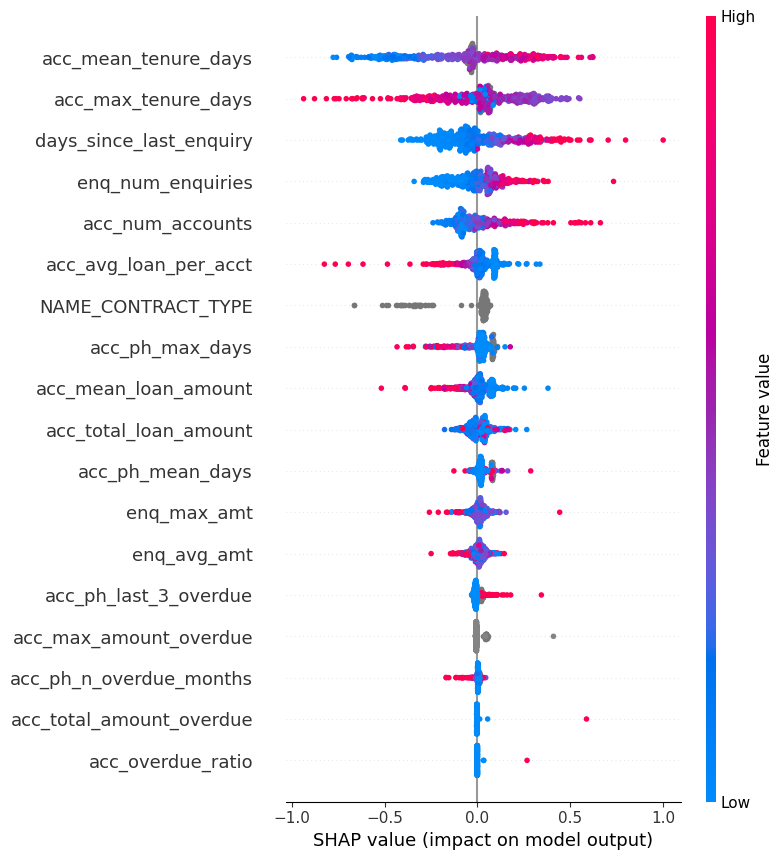

In [38]:
# SHAP explainability
import shap

# Create SHAP explainer for final model
explainer = shap.TreeExplainer(final_model)

# Use a sample of training data (avoid huge)
sample_X = X.sample(min(500, len(X)), random_state=SEED)

# Compute SHAP values
shap_values = explainer(sample_X)

# Plot summary
shap.summary_plot(shap_values, sample_X)
